#FINRL Train Stock Trading
https://github.com/AI4Finance-LLC/FinRL/blob/master/finrl/train.py

In this work SAC used as RL agorithm rather than D Q-Network. The reason of this choice explained in "Train Model" section.

Multi-stock trading data used in train and trade data part. So this work related to multi-stock trading with RL. DOW The latest market data for all 30 stocks in the Dow Jones Industrial Average. So in this work there is "BIST_30_TICKER" relates with that.



#SETUP

In [1]:
 # Install the unstable development version in Jupyter notebook:
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-yrf0x08v
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-yrf0x08v
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-vrgu88s9/pyfolio_17d5d61ffa91433fad4852cf2aa2bfea
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-vrgu88s9/pyfolio_17d5d61ffa91433fad4852cf2aa2bfea


In [2]:
#for data download part -- yahoo finance
!pip install yfinance

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing

matplotlib.use("Agg")
import datetime

from finrl.apps import config
from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.neo_finrl.env_stock_trading.env_stocktrading_stoploss import StockTradingEnvStopLoss
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

import itertools


/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [4]:
import pandas as pd
import yfinance as yf

#Collect Data

In [5]:
stockList = ["AKBNK.IS","ARCLK.IS","ASELS.IS","BIMAS.IS","DOHOL.IS","EKGYO.IS","EREGL.IS","FROTO.IS","GARAN.IS","GUBRF.IS","HALKB.IS","ISCTR.IS","KCHOL.IS","KOZAA.IS","KOZAL.IS",
"KRDMD.IS","PETKM.IS","PGSUS.IS","SAHOL.IS","SASA.IS","SISE.IS","TAVHL.IS","TCELL.IS","THYAO.IS","TKFEN.IS","TTKOM.IS","TUPRS.IS","VAKBN.IS","VESTL.IS","YKBNK.IS"]
len(stockList)

30

In [6]:
# print("==============Start Fetching Data===========")
# df = YahooDownloader(
#     start_date=config.START_DATE,
#     end_date=config.END_DATE,
#     ticker_list=stockList,
# ).fetch_data()

In [7]:
tickers = ["VESTL.IS","VAKBN.IS","TUPRS.IS""THYAO.IS","HALKB.IS","SASA.IS","PETKM.IS","SAHOL.IS","PGSUS.IS","GARAN.IS","AKBNK.IS","ARCLK.IS","BIMAS.IS","EREGL.IS"] # 20 tane hisse


In [8]:
date1="2015-07-27"
date2="2021-07-28"
list_data = []
for ticker in tickers:
  data = yf.download(tickers=ticker , start=date1, end=date2, interval='1d' )
  data["tic"] = ticker
  data["date"] = data.index
  data = data.reset_index()
  list_data.append(data)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- TUPRS.ISTHYAO.IS: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
list_data

[           Date       Open       High  ...   Volume       tic       date
 0    2015-07-27   4.450000   4.450000  ...  1074220  VESTL.IS 2015-07-27
 1    2015-07-28   4.450000   4.470000  ...  1609540  VESTL.IS 2015-07-28
 2    2015-07-29   4.430000   4.460000  ...   981396  VESTL.IS 2015-07-29
 3    2015-07-30   4.480000   4.490000  ...   871776  VESTL.IS 2015-07-30
 4    2015-07-31   4.480000   4.650000  ...  6003500  VESTL.IS 2015-07-31
 ...         ...        ...        ...  ...      ...       ...        ...
 1526 2021-07-14  30.420000  31.440001  ...  2070274  VESTL.IS 2021-07-14
 1527 2021-07-16  31.420000  31.620001  ...  1660750  VESTL.IS 2021-07-16
 1528 2021-07-19  31.400000  32.160000  ...  1369061  VESTL.IS 2021-07-19
 1529 2021-07-26  32.200001  32.279999  ...  2489134  VESTL.IS 2021-07-26
 1530 2021-07-27  31.980000  32.099998  ...  1726049  VESTL.IS 2021-07-27
 
 [1531 rows x 9 columns],
            Date  Open  High   Low  ...  Adj Close    Volume       tic       date
 0

In [10]:
import pandas as pd
df = pd.concat(list_data)

del df['Date']

In [11]:

df.isna().sum()
multi_ticker_df = df.ffill().bfill()
print(multi_ticker_df)

           Open       High        Low  ...      Volume       tic       date
0      4.450000   4.450000   4.330000  ...   1074220.0  VESTL.IS 2015-07-27
1      4.450000   4.470000   4.370000  ...   1609540.0  VESTL.IS 2015-07-28
2      4.430000   4.460000   4.410000  ...    981396.0  VESTL.IS 2015-07-29
3      4.480000   4.490000   4.430000  ...    871776.0  VESTL.IS 2015-07-30
4      4.480000   4.650000   4.480000  ...   6003500.0  VESTL.IS 2015-07-31
...         ...        ...        ...  ...         ...       ...        ...
1526  17.990000  18.400000  17.990000  ...  19197906.0  EREGL.IS 2021-07-14
1527  18.250000  18.250000  17.910000  ...  17163796.0  EREGL.IS 2021-07-16
1528  18.000000  18.030001  17.850000  ...   5709839.0  EREGL.IS 2021-07-19
1529  18.040001  18.250000  18.000000  ...  23665915.0  EREGL.IS 2021-07-26
1530  18.070000  18.490000  17.969999  ...  25081610.0  EREGL.IS 2021-07-27

[18372 rows x 8 columns]


In [12]:
type(multi_ticker_df)

pandas.core.frame.DataFrame

In [13]:
multi_ticker_df.columns= multi_ticker_df.columns.str.strip().str.lower()
multi_ticker_df.columns

Index(['open', 'high', 'low', 'close', 'adj close', 'volume', 'tic', 'date'], dtype='object')

In [14]:
def prefill(multi_ticker_df)  :
    df = multi_ticker_df.copy()
    df=df.sort_values(['date','tic'],ignore_index=True)
    df.index = df.date.factorize()[0]
    merged_closes = df.pivot_table(index = 'date',columns = 'tic', values = 'close')

    print(merged_closes.isna().sum())
    merged_closes = merged_closes.ffill().bfill()

    # print(merged_closes.isna().sum())
    # print(merged_closes)
    tics = merged_closes.columns
    df = df[df.tic.isin(tics)]
    df = df.reset_index()
    del df['index']
    return df
multiticker_df = prefill(multi_ticker_df)


tic
AKBNK.IS    0
ARCLK.IS    0
BIMAS.IS    0
EREGL.IS    0
GARAN.IS    0
HALKB.IS    0
PETKM.IS    0
PGSUS.IS    0
SAHOL.IS    0
SASA.IS     0
VAKBN.IS    0
VESTL.IS    0
dtype: int64


In [15]:
print(multiticker_df)

            open       high        low  ...      volume       tic       date
0       6.182181   6.182181   6.122160  ...  13466375.0  AKBNK.IS 2015-07-27
1      14.750000  14.950000  14.500000  ...   1976842.0  ARCLK.IS 2015-07-27
2      23.525000  23.799999  23.325001  ...    628882.0  BIMAS.IS 2015-07-27
3       3.990000   4.040000   3.960000  ...   6776403.0  EREGL.IS 2015-07-27
4       7.900000   7.910000   7.740000  ...  63095366.0  GARAN.IS 2015-07-27
...          ...        ...        ...  ...         ...       ...        ...
18367  67.699997  71.949997  67.199997  ...   3505926.0  PGSUS.IS 2021-07-27
18368   9.070000   9.300000   9.020000  ...  17634418.0  SAHOL.IS 2021-07-27
18369  29.680000  30.299999  29.340000  ...  15605997.0   SASA.IS 2021-07-27
18370   3.430000   3.440000   3.390000  ...  30871452.0  VAKBN.IS 2021-07-27
18371  31.980000  32.099998  31.740000  ...   1726049.0  VESTL.IS 2021-07-27

[18372 rows x 8 columns]


#Feature Engineering

In [16]:
print("==============Start Feature Engineering===========")
tech_indicator_list=config.TECHNICAL_INDICATORS_LIST

fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list=tech_indicator_list,
    use_turbulence=True,
    user_defined_feature=False,
)

==============Start Feature Engineering===========


In [17]:
tech_indicator_list

['macd', 'rsi_30', 'cci_30', 'dx_30']

In [18]:
processed = fe.preprocess_data(multiticker_df)


Successfully added technical indicators
Successfully added turbulence index


In [19]:
processed

,open,high,low,close,adj close,volume,tic,date,macd,rsi_30,cci_30,dx_30,turbulence
0,6.182181,6.182181,6.122160,6.165032,5.510608,13466375.0,AKBNK.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
1,14.750000,14.950000,14.500000,14.600000,11.878804,1976842.0,ARCLK.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
2,23.525000,23.799999,23.325001,23.600000,19.072001,628882.0,BIMAS.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
3,3.990000,4.040000,3.960000,4.040000,1.965522,6776403.0,EREGL.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
4,7.900000,7.910000,7.740000,7.760000,6.942376,63095366.0,GARAN.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18367,67.699997,71.949997,67.199997,71.400002,71.400002,3505926.0,PGSUS.IS,2021-07-27,-2.136392,44.699076,-115.962311,31.513849,7.048507
18368,9.070000,9.300000,9.020000,9.290000,9.290000,17634418.0,SAHOL.IS,2021-07-27,0.000826,53.078843,5.758155,11.416987,7.048507
18369,29.680000,30.299999,29.340000,29.540001,29.540001,15605997.0,SASA.IS,2021-07-27,-0.567082,47.213518,-26.532921,13.879146,7.048507
18370,3.430000,3.440000,3.390000,3.420000,3.420000,30871452.0,VAKBN.IS,2021-07-27,-0.036190,42.210935,-143.798826,35.035782,7.048507


In [20]:
processed_full = processed.sort_values(['date','tic'])
processed_full= processed_full.ffill().bfill()

In [21]:
processed_full

,open,high,low,close,adj close,volume,tic,date,macd,rsi_30,cci_30,dx_30,turbulence
0,6.182181,6.182181,6.122160,6.165032,5.510608,13466375.0,AKBNK.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
1,14.750000,14.950000,14.500000,14.600000,11.878804,1976842.0,ARCLK.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
2,23.525000,23.799999,23.325001,23.600000,19.072001,628882.0,BIMAS.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
3,3.990000,4.040000,3.960000,4.040000,1.965522,6776403.0,EREGL.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
4,7.900000,7.910000,7.740000,7.760000,6.942376,63095366.0,GARAN.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18367,67.699997,71.949997,67.199997,71.400002,71.400002,3505926.0,PGSUS.IS,2021-07-27,-2.136392,44.699076,-115.962311,31.513849,7.048507
18368,9.070000,9.300000,9.020000,9.290000,9.290000,17634418.0,SAHOL.IS,2021-07-27,0.000826,53.078843,5.758155,11.416987,7.048507
18369,29.680000,30.299999,29.340000,29.540001,29.540001,15605997.0,SASA.IS,2021-07-27,-0.567082,47.213518,-26.532921,13.879146,7.048507
18370,3.430000,3.440000,3.390000,3.420000,3.420000,30871452.0,VAKBN.IS,2021-07-27,-0.036190,42.210935,-143.798826,35.035782,7.048507


# Training & Trading data split

In [22]:
date1="2015-07-27"
date2="2021-07-28"
date3= "2020-07-27"

In [23]:
train = data_split(processed_full,date1, date3)
trade = data_split(processed_full, date3, date2)


# Calculate state action space


In [24]:
stock_dimension = len(train.tic.unique()) # number of tickers
state_space = (
        1
        + 2 * stock_dimension
        + len(config.TECHNICAL_INDICATORS_LIST) * stock_dimension)

In [25]:
stock_dimension ,state_space

(12, 73)

# ENV CREATE

In [26]:
env_kwargs = {
        "hmax": 100, 
        "initial_amount": 1000000, 
        "buy_cost_pct": 0.001, 
        "sell_cost_pct": 0.001, 
}

In [27]:
e_train_gym = StockTradingEnvStopLoss(df=train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()

caching data
data cached!


#SET AGENT

In [28]:
agent = DRLAgent(env=env_train)
#DRLAGENT hazır kütüphaneden alınmakta. Kendimiz çeşitlendirebilir miyiz?

#Model Training
We use Soft Actor-Critic (SAC) for multiple stock trading, because it is one of the most recent state-of-art algorithms. SAC is featured by its stability.

For more info about SAC :https://bit.ly/3yuKz8a

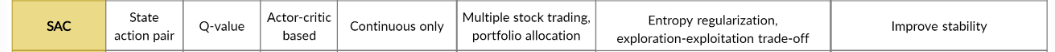

In [29]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime("%Y%m%d-%Hh%M")

model_sac = agent.get_model("sac")
trained_sac = agent.train_model(model=model_sac, tb_log_name="sac", total_timesteps=10000 )

==============Model Training===========
{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device
Logging to tensorboard_log/sac/sac_9
EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
   1|   1|LOW PROFIT     |$999,926       |$1,000,000     |0.00000%  |-0.00000% |99.99%    
   1|   2|LOW PROFIT     |$999,852       |$1,000,001     |-0.00000% |0.00013%  |99.99%    
   1|   3|LOW PROFIT     |$999,679       |$999,998       |-0.00020% |-0.00021% |99.97%    
   1|   6|LOW PROFIT     |$999,119       |$999,982       |-0.00032% |-0.00183% |99.91%    
   1|   7|LOW PROFIT     |$999,192       |$999,986       |-0.00029% |-0.00142% |99.92%    
   1|   8|LOW PROFIT     |$998,870       |$999,985       |-0.00055% |-0.00148% |99.89%    
   1|   9|update         |$998,870       |$999,985       |-0.00055% |-0.00148% |99.89%    
   1|   9|LOW PROFIT     |$998,427       

/usr/local/lib/python3.7/dist-packages/finrl/neo_finrl/env_stock_trading/env_stocktrading_stoploss.py:381: RuntimeWarning: divide by zero encountered in true_divide
  self.avg_buy_price = np.where(buys > 0, self.avg_buy_price + ((closings - self.avg_buy_price) / self.n_buys), self.avg_buy_price) #incremental average


Görüntülenen çıkış son 5000 satıra kısaltıldı.
   1|  22|LOW PROFIT     |$997,140       |$1,000,082     |-0.00027% |0.00821%  |99.71%    
   1|  23|LOW PROFIT     |$997,164       |$1,000,059     |-0.00033% |0.00589%  |99.71%    
   1|  24|LOW PROFIT     |$997,378       |$1,000,018     |-0.00023% |0.00180%  |99.74%    
   1|  25|LOW PROFIT     |$997,228       |$1,000,014     |0.00006%  |0.00135%  |99.72%    
   1|  26|LOW PROFIT     |$997,425       |$999,995       |-0.00034% |-0.00052% |99.74%    
   1|  27|LOW PROFIT     |$997,382       |$1,000,007     |-0.00022% |0.00071%  |99.74%    
   1|  29|update         |$997,755       |$999,962       |-0.00028% |-0.00384% |99.78%    
   1|  29|LOW PROFIT     |$997,599       |$999,979       |-0.00013% |-0.00211% |99.76%    
   1|  30|LOW PROFIT     |$997,274       |$1,000,048     |-0.00029% |0.00483%  |99.72%    
   1|  31|LOW PROFIT     |$997,056       |$1,000,055     |0.00006%  |0.00545%  |99.70%    
   1|  32|LOW PROFIT     |$996,889       |$

#Save Model

In [30]:
!mkdir -p saved_model
trained_sac.save('saved_model/my_modelBIST.h5') 

In [31]:
trained_sac

In [32]:
print("==============Start Trading===========")
e_trade_gym = StockTradingEnvStopLoss(df=trade, turbulence_threshold=250, **env_kwargs)



==============Start Trading===========
caching data
data cached!


In [33]:
df_account_value, df_actions = DRLAgent.DRL_prediction( model=trained_sac, environment = e_trade_gym)


[[ 1. -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1.]]
EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
[[ 1. -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1.]]
[[ 1. -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1.]]
[[ 1. -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1.]]
[[ 1. -1.  1. -1.  1.  1.  1.  1. -1.  1. -1.  1.]]
[[ 1. -1.  1. -1.  1.  1.  1.  1. -1.  1. -1.  1.]]


/usr/local/lib/python3.7/dist-packages/finrl/neo_finrl/env_stock_trading/env_stocktrading_stoploss.py:381: RuntimeWarning: divide by zero encountered in true_divide
  self.avg_buy_price = np.where(buys > 0, self.avg_buy_price + ((closings - self.avg_buy_price) / self.n_buys), self.avg_buy_price) #incremental average


[[ 1. -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1.]]
   1|   6|LOW PROFIT     |$995,596       |$1,000,055     |0.00075%  |0.00546%  |99.55%    
[[ 1. -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1.]]
   1|   7|LOW PROFIT     |$994,995       |$1,000,044     |0.00050%  |0.00442%  |99.50%    
[[ 1. -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1.]]
   1|   8|LOW PROFIT     |$994,394       |$1,000,088     |0.00055%  |0.00880%  |99.43%    
[[ 1. -1.  1. -1.  1.  1.  1.  1. -1.  1. -1.  1.]]
   1|   9|update         |$994,394       |$1,000,088     |0.00055%  |0.00880%  |99.43%    
[[ 1. -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1.]]
   1|  10|LOW PROFIT     |$992,895       |$1,000,009     |0.00055%  |0.00087%  |99.29%    
[[ 1. -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1.]]
   1|  11|LOW PROFIT     |$992,294       |$999,990       |0.00008%  |-0.00098% |99.23%    
[[ 1. -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1.]]
[[ 1. -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1.]]
[[ 1. -1.  1. -1.  1.  1.  1.  1. -1. 

In [37]:
df_account_value

,cash,asset_value,total_assets,reward,date
0,1000000.000000,0.000000,1.000000e+06,0.000000,2020-09-24
1,999299.300000,716.518018,1.000016e+06,0.000000,2020-09-25
2,998598.600000,1422.419204,1.000021e+06,0.000008,2020-09-28
3,997897.900000,2091.931607,9.999898e+05,0.000007,2020-09-29
4,997197.200000,2778.511922,9.999757e+05,-0.000003,2020-09-30
...,...,...,...,...,...
203,918554.453165,87278.422482,1.005833e+06,0.000021,2021-07-14
204,917753.653165,91961.700486,1.009715e+06,0.000029,2021-07-16
205,916952.853165,91749.107152,1.008702e+06,0.000047,2021-07-19
206,916152.053165,92228.854741,1.008381e+06,0.000042,2021-07-26


In [38]:
df_actions

,date,actions,transactions
0,2020-09-24,"[478.00002098083496, -2326.0000228881836, 6850...","[20.920501173787486, -0.0, 1.4598540145985401,..."
1,2020-09-25,"[503.99999618530273, -2315.999984741211, 6894....","[19.841269991445316, -0.0, 1.4503263876148642,..."
2,2020-09-28,"[511.9999885559082, -2328.000068664551, 6950.0...","[19.531250436557468, -0.0, 1.4388489208633093,..."
3,2020-09-29,"[501.99999809265137, -2318.000030517578, 6840....","[19.920318800786838, -0.0, 1.4619882714792827,..."
4,2020-09-30,"[498.9999771118164, -2310.0000381469727, 6850....","[20.04008107952115, -0.0, 1.4598540145985401, ..."
...,...,...,...
203,2021-07-14,"[523.9999771118164, -3234.000015258789, 6120.0...","[19.08397029923171, -0.0, 1.6339869077347535, ..."
204,2021-07-16,"[528.9999961853027, -3270.0000762939453, 6170....","[18.903591818736256, -0.0, 1.6207455229087406,..."
205,2021-07-19,"[523.9999771118164, -3341.9998168945312, 6175....","[19.08397029923171, -0.0, 1.6194331983805668, ..."
206,2021-07-26,"[515.9999847412109, -3272.0001220703125, 6109....","[19.379845534327472, -0.0, 1.636661252002404, ..."


In [34]:
e_trade_gym
test_env, test_obs = e_trade_gym.get_sb_env()


In [39]:
df_account_value

profit_list = []
ac_val = list(df_account_value["total_assets"])
print(ac_val)
turn =len(ac_val)
for i in range(turn):
  
  if i != turn-1:

    diff = ac_val[i+1]  - ac_val[i]
    profit_list.append(diff)
  else:
    profit_list.append(float(0))
    
print(profit_list)


[1000000.0, 1000015.8180176171, 1000021.0192039703, 999989.8316069035, 999975.7119220761, 1000045.0814469669, 1000054.5690028504, 1000044.2327099558, 1000087.9899488168, 1000054.9414159504, 1000008.6591270748, 999990.2134426909, 1000077.8782664263, 1000184.909022026, 1000143.2580067407, 1000172.2323556077, 1000053.1250304356, 1000174.9888303801, 1000389.0761562663, 1000341.8071942532, 1000369.8462993957, 1000075.2309606388, 999974.2314624862, 999447.666161678, 999549.7946899007, 999118.016306325, 998724.7262258109, 998703.3709281669, 999176.406897934, 999427.5112317087, 999646.4377772722, 999817.7308850042, 1000695.0515781295, 1001116.4443485636, 1002230.6494540586, 1002233.8073010565, 1002312.0306314251, 1002358.0313531763, 1001596.6930640709, 1002231.1783346299, 1002801.7810389695, 1002952.2787655138, 1002421.2473666432, 1002487.7753313811, 1002752.4582185042, 1003235.3821325728, 1002977.3573477534, 1001850.2692985722, 1003041.7446085121, 1002938.5934341849, 1002987.1706810348, 10033

In [40]:
new_df = df_account_value.copy()

new_df["diff"] = np.array(profit_list)

new_df

,cash,asset_value,total_assets,reward,date,diff
0,1000000.000000,0.000000,1.000000e+06,0.000000,2020-09-24,15.818018
1,999299.300000,716.518018,1.000016e+06,0.000000,2020-09-25,5.201186
2,998598.600000,1422.419204,1.000021e+06,0.000008,2020-09-28,-31.187597
3,997897.900000,2091.931607,9.999898e+05,0.000007,2020-09-29,-14.119685
4,997197.200000,2778.511922,9.999757e+05,-0.000003,2020-09-30,69.369525
...,...,...,...,...,...,...
203,918554.453165,87278.422482,1.005833e+06,0.000021,2021-07-14,3882.478004
204,917753.653165,91961.700486,1.009715e+06,0.000029,2021-07-16,-1013.393334
205,916952.853165,91749.107152,1.008702e+06,0.000047,2021-07-19,-321.052412
206,916152.053165,92228.854741,1.008381e+06,0.000042,2021-07-26,-835.718075


In [41]:
%matplotlib inline

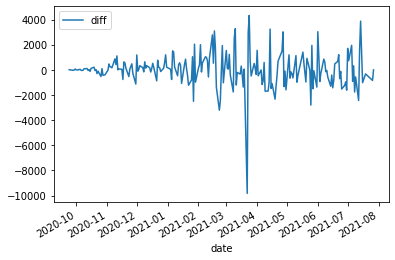

In [42]:
# hesaptaki günlük kar-zarar grafiği
new_df.plot(x='date', y='diff', kind = 'line')

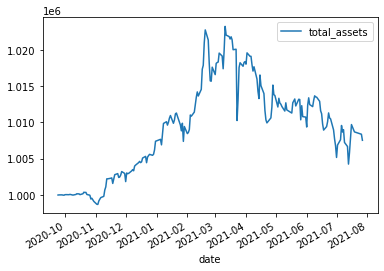

In [44]:
# total hesaptaki maliyetin değişimi
new_df.plot(x='date', y='total_assets', kind = 'line')

# 1 Day test

In [48]:
print("==============Start Trading===========")
trade_1day = data_split(processed_full, "2021-07-10", "2021-07-17")

e_trade_gym_1day = StockTradingEnvStopLoss(df=trade_1day, turbulence_threshold=250, **env_kwargs)

df_account_value_1day, df_actions_1day = DRLAgent.DRL_prediction( model=trained_sac, environment = e_trade_gym_1day)


==============Start Trading===========
caching data
data cached!
[[ 1. -1.  1. -1.  1.  1.  1.  1. -1.  1. -1.  1.]]
EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
[[ 1. -1.  1. -1.  1.  1.  1.  1. -1.  1. -1.  1.]]
[[ 1. -1.  1. -1.  1.  1.  1.  1. -1.  1. -1.  1.]]
   1|   2|Last Date      |$999,199       |$1,000,017     |0.00084%  |0.00168%  |99.92%    
hit end!
[None] [None]


/usr/local/lib/python3.7/dist-packages/finrl/neo_finrl/env_stock_trading/env_stocktrading_stoploss.py:381: RuntimeWarning: divide by zero encountered in true_divide
  self.avg_buy_price = np.where(buys > 0, self.avg_buy_price + ((closings - self.avg_buy_price) / self.n_buys), self.avg_buy_price) #incremental average


In [52]:
import os
cwd = os.getcwd()
cwd

'/content'

In [53]:
import os
os.chdir('/content/saved_model')


with open("./" + "/df_account_value_BIST" + now + ".csv", 'a') as f1:
    df_account_value.to_csv(f1, header=False)

with open("./"+ "/df_actions_BIST" + now + ".csv", 'a') as f2:
    df_actions.to_csv(f2, header=False)




#Backtesting 

In [55]:
# print("==============Get Backtest Results===========")
# perf_stats_all = backtest_stats(df_account_value)
# perf_stats_all = pd.DataFrame(perf_stats_all)
# perf_stats_all.to_csv("./" +"/perf_stats_all_BIST" + now + ".csv")


 #Understanding Format of Variables:

In [56]:
train

,open,high,low,close,adj close,volume,tic,date,macd,rsi_30,cci_30,dx_30,turbulence
0,6.182181,6.182181,6.122160,6.165032,5.510608,13466375.0,AKBNK.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
0,14.750000,14.950000,14.500000,14.600000,11.878804,1976842.0,ARCLK.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
0,23.525000,23.799999,23.325001,23.600000,19.072001,628882.0,BIMAS.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
0,3.990000,4.040000,3.960000,4.040000,1.965522,6776403.0,EREGL.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
0,7.900000,7.910000,7.740000,7.760000,6.942376,63095366.0,GARAN.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1281,51.000000,51.900002,50.650002,51.349998,51.349998,2002048.0,PGSUS.IS,2020-07-24,-1.015999,46.712444,-87.886699,5.067109,2.554014
1281,9.150000,9.150000,9.050000,9.100000,8.755303,5455417.0,SAHOL.IS,2020-07-24,0.065249,52.595700,-79.706951,3.445070,2.554014
1281,10.004468,10.263843,9.930361,10.123040,10.123040,29892348.0,SASA.IS,2020-07-24,0.633239,68.646562,138.956885,47.425085,2.554014
1281,4.890000,4.920000,4.840000,4.880000,4.880000,39839221.0,VAKBN.IS,2020-07-24,-0.010792,48.479858,-67.830976,7.872245,2.554014


In [57]:
trade

,open,high,low,close,adj close,volume,tic,date,macd,rsi_30,cci_30,dx_30,turbulence
0,5.800000,5.810000,5.700000,5.720000,5.578002,43319180.0,AKBNK.IS,2020-07-27,-0.032535,45.321645,-107.064136,3.281478,6.141735
0,22.240000,22.540001,22.100000,22.160000,20.744827,10243494.0,ARCLK.IS,2020-07-27,1.084334,71.838800,145.124012,62.664200,6.141735
0,74.699997,75.900002,74.250000,74.300003,69.351898,2675233.0,BIMAS.IS,2020-07-27,1.951131,65.861834,192.733720,48.082447,6.141735
0,8.410000,8.510000,8.390000,8.470000,7.452500,36658368.0,EREGL.IS,2020-07-27,0.000343,50.769015,-40.977438,1.932329,6.141735
0,7.950000,7.960000,7.770000,7.800000,7.635209,98366875.0,GARAN.IS,2020-07-27,-0.083367,43.797485,-114.132586,16.189562,6.141735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,67.699997,71.949997,67.199997,71.400002,71.400002,3505926.0,PGSUS.IS,2021-07-27,-2.136392,44.699076,-115.962311,31.513849,7.048507
248,9.070000,9.300000,9.020000,9.290000,9.290000,17634418.0,SAHOL.IS,2021-07-27,0.000826,53.078843,5.758155,11.416987,7.048507
248,29.680000,30.299999,29.340000,29.540001,29.540001,15605997.0,SASA.IS,2021-07-27,-0.567082,47.213518,-26.532921,13.879146,7.048507
248,3.430000,3.440000,3.390000,3.420000,3.420000,30871452.0,VAKBN.IS,2021-07-27,-0.036190,42.210935,-143.798826,35.035782,7.048507


In [58]:
e_train_gym

In [59]:
agent

In [60]:
model_sac

In [61]:
trained_sac

In [62]:
e_trade_gym

In [63]:
df_account_value

,cash,asset_value,total_assets,reward,date
0,1000000.000000,0.000000,1.000000e+06,0.000000,2020-09-24
1,999299.300000,716.518018,1.000016e+06,0.000000,2020-09-25
2,998598.600000,1422.419204,1.000021e+06,0.000008,2020-09-28
3,997897.900000,2091.931607,9.999898e+05,0.000007,2020-09-29
4,997197.200000,2778.511922,9.999757e+05,-0.000003,2020-09-30
...,...,...,...,...,...
203,918554.453165,87278.422482,1.005833e+06,0.000021,2021-07-14
204,917753.653165,91961.700486,1.009715e+06,0.000029,2021-07-16
205,916952.853165,91749.107152,1.008702e+06,0.000047,2021-07-19
206,916152.053165,92228.854741,1.008381e+06,0.000042,2021-07-26


In [64]:
df_actions

,date,actions,transactions
0,2020-09-24,"[478.00002098083496, -2326.0000228881836, 6850...","[20.920501173787486, -0.0, 1.4598540145985401,..."
1,2020-09-25,"[503.99999618530273, -2315.999984741211, 6894....","[19.841269991445316, -0.0, 1.4503263876148642,..."
2,2020-09-28,"[511.9999885559082, -2328.000068664551, 6950.0...","[19.531250436557468, -0.0, 1.4388489208633093,..."
3,2020-09-29,"[501.99999809265137, -2318.000030517578, 6840....","[19.920318800786838, -0.0, 1.4619882714792827,..."
4,2020-09-30,"[498.9999771118164, -2310.0000381469727, 6850....","[20.04008107952115, -0.0, 1.4598540145985401, ..."
...,...,...,...
203,2021-07-14,"[523.9999771118164, -3234.000015258789, 6120.0...","[19.08397029923171, -0.0, 1.6339869077347535, ..."
204,2021-07-16,"[528.9999961853027, -3270.0000762939453, 6170....","[18.903591818736256, -0.0, 1.6207455229087406,..."
205,2021-07-19,"[523.9999771118164, -3341.9998168945312, 6175....","[19.08397029923171, -0.0, 1.6194331983805668, ..."
206,2021-07-26,"[515.9999847412109, -3272.0001220703125, 6109....","[19.379845534327472, -0.0, 1.636661252002404, ..."
